In [1]:
!pip install vit-keras
!pip install tensorflow-addons
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
from PIL import Image
import vit_keras
from vit_keras import vit

D:\CSE299\Flutter\Anaconda\envs\A_prediction\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
D:\CSE299\Flutter\Anaconda\envs\A_prediction\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

In [2]:
# Directories
train_dir = 'D:/Permanent/train'
test_dir = 'D:/Permanent/test'

In [3]:
# Load training data
image_paths = []
age_labels = []
gender_labels = []
image_ids = []  # Define an array for image IDs

for filename in os.listdir(train_dir):
    image_path = os.path.join(train_dir, filename)
    temp = filename.split('_')
    image_id = temp[0]  # Extracting image ID
    gender = int(temp[1])
    age = int(temp[2].split()[0])  # Extracting age from filename
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    image_ids.append(image_id)  # Store image IDs

# Convert to numpy arrays
image_ids = np.array(image_ids)
train_df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels, 'image_id': image_ids})


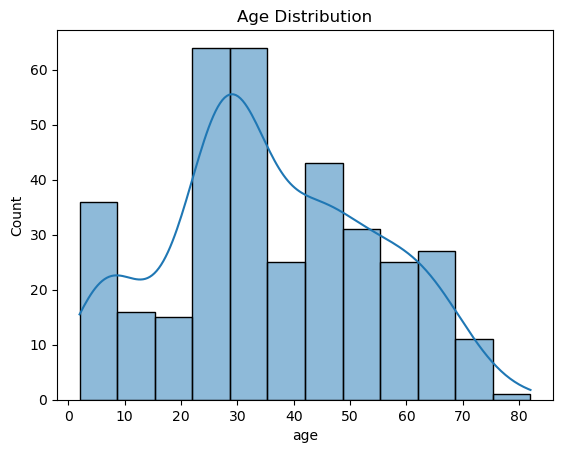

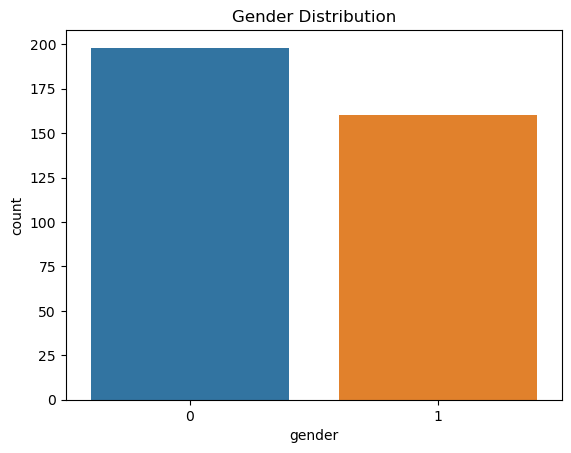

  0%|          | 0/358 [00:00<?, ?it/s]

In [4]:
# Exploratory Data Analysis
sns.histplot(train_df['age'], kde=True)
plt.title("Age Distribution")
plt.show()

sns.countplot(x='gender', data=train_df)
plt.title("Gender Distribution")
plt.show()

# Load Images
def load_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in tqdm(image_paths):
        img = load_img(img_path, target_size=target_size, color_mode="rgb")
        img = np.array(img) / 255.0
        images.append(img)
    return np.array(images)

X_images = load_images(train_df['image'])
y_gender = np.array(train_df['gender'])
y_age = np.array(train_df['age'])

In [5]:
# Split Train-Validation
X_train, X_val, y_train_gender, y_val_gender, y_train_age, y_val_age = train_test_split(
    X_images, y_gender, y_age, test_size=0.2, stratify=y_gender, random_state=42
)

In [6]:
# Balance classes for Gender Classification
ros = RandomOverSampler()
X_train_gender, y_train_gender_balanced = ros.fit_resample(X_train.reshape(len(X_train), -1), y_train_gender)
X_train_gender = X_train_gender.reshape(-1, 224, 224, 3)

# Balance classes for Age Regression
X_train_age, y_train_age_balanced = ros.fit_resample(X_train.reshape(len(X_train), -1), y_train_age)
X_train_age = X_train_age.reshape(-1, 224, 224, 3)


In [7]:
# Gender Model using ViT (vit_b16)
def create_gender_model(input_shape=(224, 224, 3)):
    # Use ViT b16 from vit_keras library with the top layers excluded
    vit_model = vit.vit_b16(
        image_size=224,
        pretrained=True,
        include_top=False,  # Exclude the final classification layers
        pretrained_top=False
    )
    
    # Freeze the base layers of ViT
    vit_model.trainable = False
    
    # Add custom layers on top of ViT for Gender classification
    x = Flatten()(vit_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout layer for regularization
    
    # Output layer for binary classification (Gender: 0 or 1)
    output = Dense(1, activation='sigmoid')(x)  # Use sigmoid for binary output
    
    model = Model(inputs=vit_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create and compile the Gender model
gender_model = create_gender_model()
gender_model.summary()

# Train the Gender model
history_gender = gender_model.fit(X_train_gender, y_train_gender_balanced, validation_data=(X_val, y_val_gender),
                                  epochs=20, batch_size=32)

D:\CSE299\Flutter\Anaconda\envs\A_prediction\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))        

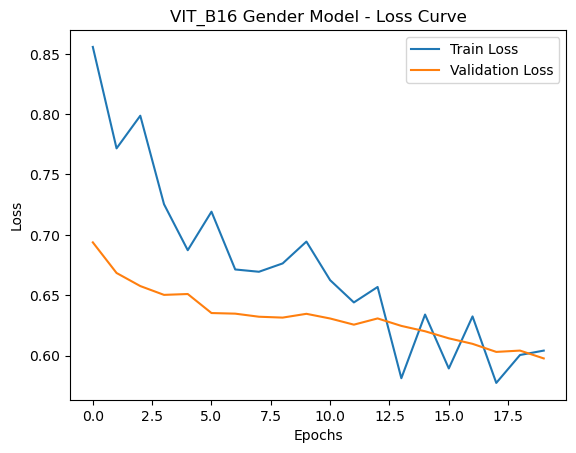

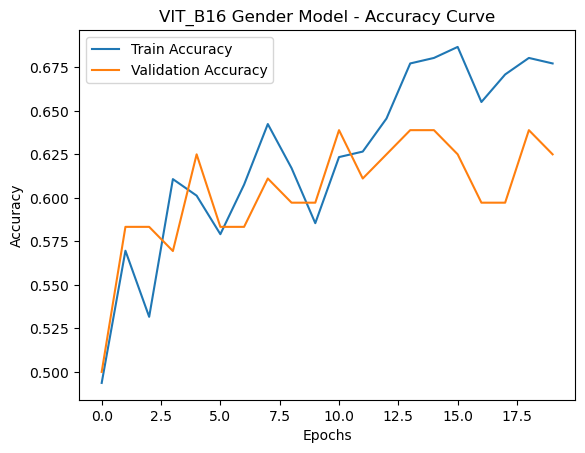

3/3 [==============================] - 15s 3s/step


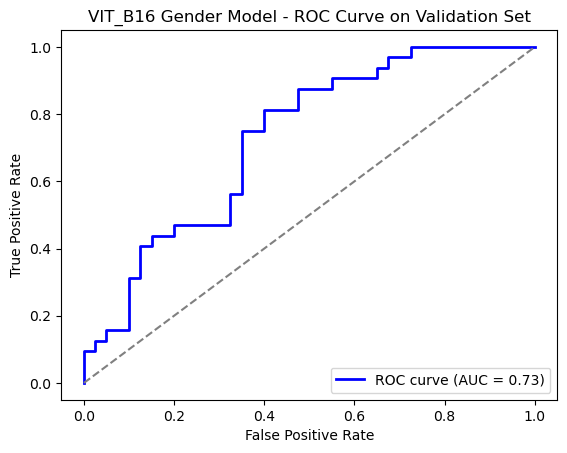

In [8]:
# Plot Gender Model Loss Curve
plt.figure()
plt.plot(history_gender.history['loss'], label='Train Loss')
plt.plot(history_gender.history['val_loss'], label='Validation Loss')
plt.title('VIT_B16 Gender Model - Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('VIT_B16 Gender Model - Loss Curve.png', bbox_inches='tight')  # Save the figure
plt.show()

# Plot Gender Model Accuracy Curve
plt.figure()
plt.plot(history_gender.history['accuracy'], label='Train Accuracy')
plt.plot(history_gender.history['val_accuracy'], label='Validation Accuracy')
plt.title('VIT_B16 Gender Model - Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('VIT_B16 Gender Model - Accuracy Curve.png', bbox_inches='tight')  # Save the figure
plt.show()

# Gender Model - ROC Curve on Validation
y_val_gender_pred_prob = gender_model.predict(X_val).ravel()
val_fpr, val_tpr, _ = roc_curve(y_val_gender, y_val_gender_pred_prob)
roc_auc = auc(val_fpr, val_tpr)

plt.figure()
plt.plot(val_fpr, val_tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VIT_B16 Gender Model - ROC Curve on Validation Set')
plt.legend(loc="lower right")
plt.savefig('VIT_B16 Gender Model - ROC Curve on Validation Set.png', bbox_inches='tight')  # Save the figure
plt.show()

In [9]:
# Reshape the input images into 2D (number of samples, number of features)
X_train_flattened = X_train.reshape(len(X_train), -1)  # Flatten to 2D (num_samples, num_features)

# Apply RandomOverSampler to balance the age labels
ros = RandomOverSampler(random_state=42)
X_train_age_balanced, y_train_age_balanced = ros.fit_resample(X_train_flattened, y_train_age)

# Reshape the balanced data back to the original image shape (224, 224, 3)
X_train_age_balanced = X_train_age_balanced.reshape(-1, 224, 224, 3)

# Verify the new shape of X_train_age_balanced and y_train_age_balanced
print(X_train_age_balanced.shape)  # Should be (number_of_samples, 224, 224, 3)
print(y_train_age_balanced.shape)  # Should match the number of samples in X_train_age_balanced

(966, 224, 224, 3)
(966,)


In [10]:
# Age Model using ViT (vit_b16)
def create_age_model(input_shape=(224, 224, 3)):
    # Use ViT b16 from vit_keras library with the top layers excluded
    vit_model = vit.vit_b16(
        image_size=224,
        pretrained=True,
        include_top=False,  # Exclude the final classification layers
        pretrained_top=False
    )
    
    # Freeze the base layers of ViT
    vit_model.trainable = False
    
    # Add custom layers on top of ViT for Age regression
    x = Flatten()(vit_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout layer for regularization
    
    # Output layer for Age regression (no activation function)
    output = Dense(1)(x)  # Age regression (continuous output)
    
    model = Model(inputs=vit_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])
    
    return model

# Reshape and balance the data for training
X_train_flattened = X_train.reshape(len(X_train), -1)  # Flatten the images
ros = RandomOverSampler(random_state=42)
X_train_age_balanced, y_train_age_balanced = ros.fit_resample(X_train_flattened, y_train_age)
X_train_age_balanced = X_train_age_balanced.reshape(-1, 224, 224, 3)  # Reshape back to original image shape

# Create and compile the Age model
age_model = create_age_model()
age_model.summary()

# Train the Age model
history_age = age_model.fit(X_train_age_balanced, y_train_age_balanced, validation_data=(X_val, y_val_age),
                            epochs=20, batch_size=32) 

D:\CSE299\Flutter\Anaconda\envs\A_prediction\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_1 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

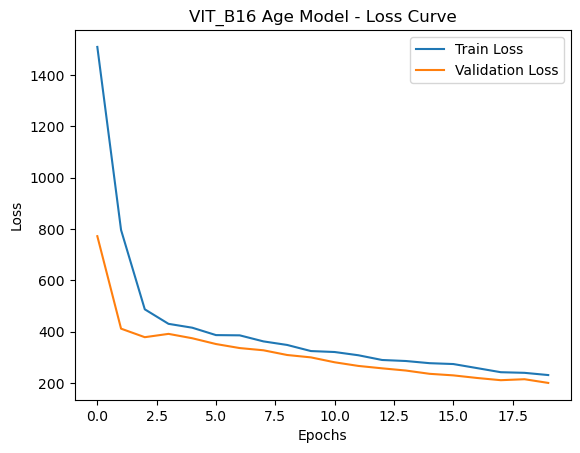

In [11]:
# Plot Age Model Loss Curve
plt.figure()
plt.plot(history_age.history['loss'], label='Train Loss')
plt.plot(history_age.history['val_loss'], label='Validation Loss')
plt.title('VIT_B16 Age Model - Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('VIT_B16 Age Model - Loss Curve.png', bbox_inches='tight')  # Save the figure
plt.show()

In [12]:
# Load test images
test_image_paths = []
test_age_labels = []
test_gender_labels = []
test_image_ids = []  # Define an array for test image IDs

for filename in os.listdir(test_dir):
    image_path = os.path.join(test_dir, filename)
    temp = filename.split('_')
    image_id = temp[0]  # Extracting image ID
    gender = int(temp[1])
    age = int(temp[2].split()[0])  # Extracting age from filename
    test_image_paths.append(image_path)
    test_age_labels.append(age)
    test_gender_labels.append(gender)
    test_image_ids.append(image_id)  # Store test image IDs

# Convert to numpy arrays
test_image_ids = np.array(test_image_ids)
test_df = pd.DataFrame({'image': test_image_paths, 'age': test_age_labels, 'gender': test_gender_labels, 'image_id': test_image_ids})
X_test_images = load_images(test_df['image'])
y_test_gender = np.array(test_df['gender'])
y_test_age = np.array(test_df['age'])

  0%|          | 0/79 [00:00<?, ?it/s]

3/3 [==============================] - 13s 4s/step
Gender Test Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.83      0.76        41
           1       0.77      0.61      0.68        38

    accuracy                           0.72        79
   macro avg       0.73      0.72      0.72        79
weighted avg       0.73      0.72      0.72        79

Confusion Matrix:
 [[34  7]
 [15 23]]


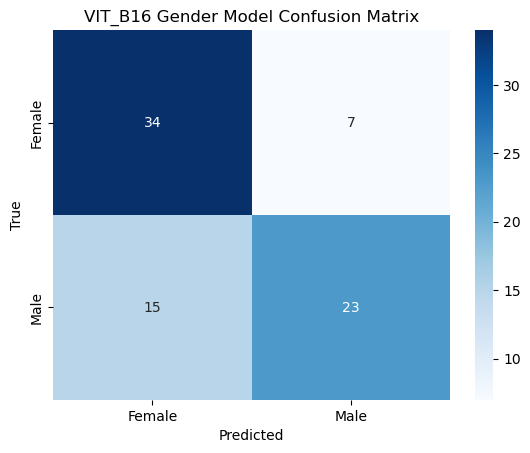

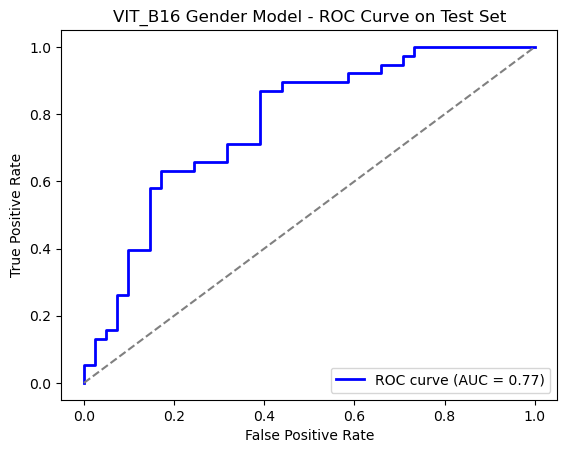

In [13]:
# Gender Model - Test Set Evaluation
y_pred_gender_test_prob = gender_model.predict(X_test_images).ravel()
y_pred_gender_test = (y_pred_gender_test_prob > 0.5).astype(int)

# Print classification report
print("Gender Test Classification Report:\n", classification_report(y_test_gender, y_pred_gender_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_gender, y_pred_gender_test)
print("Confusion Matrix:\n", conf_matrix)

# Plotting the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('VIT_B16 Gender Model Confusion Matrix')
plt.savefig('VIT_B16 Gender Model confusion_matrix.png', bbox_inches='tight')  # Save the figure
plt.show()

# Plot ROC Curve for Gender Classification
test_fpr, test_tpr, _ = roc_curve(y_test_gender, y_pred_gender_test_prob)
roc_auc = auc(test_fpr, test_tpr)

plt.figure()
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VIT_B16 Gender Model - ROC Curve on Test Set')
plt.legend(loc="lower right")
plt.savefig('VIT_B16 Gender Model - ROC Curve on Test Set.png', bbox_inches='tight')  # Save the figure
plt.show()

In [14]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Start time before prediction
start_time = time.time()

# Age Model - Test Set Evaluation
y_pred_age_test = age_model.predict(X_test_images).ravel()

# End time after prediction
end_time = time.time()

# Calculate the time taken for prediction
prediction_time = end_time - start_time

# Evaluation metrics for Age Model
mse_age = mean_squared_error(y_test_age, y_pred_age_test)
mae_age = mean_absolute_error(y_test_age, y_pred_age_test)
rmse_age = np.sqrt(mse_age)  # Calculating RMSE
r2_age = r2_score(y_test_age, y_pred_age_test)

# Calculate MAPE
mape_age = np.mean(np.abs((y_test_age - y_pred_age_test) / y_test_age)) * 100  # MAPE calculation

# Print evaluation results
print(f"Age Model Evaluation:")
print(f"MSE: {mse_age:.2f}")
print(f"MAE: {mae_age:.2f}")
print(f"RMSE: {rmse_age:.2f}")
print(f"R²: {r2_age:.2f}")
print(f"MAPE: {mape_age:.2f}%")

# Print time taken for predictions
print(f"Time taken to predict ages of {len(X_test_images)} images: {prediction_time:.4f} seconds")


3/3 [==============================] - 16s 4s/step
Age Model Evaluation:
MSE: 159.98
MAE: 10.24
RMSE: 12.65
R²: 0.20
MAPE: 37.38%
Time taken to predict ages of 79 images: 16.1463 seconds
